In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_datareader as web
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [ ]:
start = '1971-01-01'
end = datetime.today().strftime('%Y-%m-%d')

asset = ['^IXIC', 'VUSTX']
ratio = [6, 4]
leverage = [1, 1]

initial_balance = 1000
rebalancing_interval = 3 # 월 단위

In [ ]:
# 첫 거래일 계산
for i in range(len(asset)):
  if datetime.strptime(start, '%Y-%m-%d') <= web.get_data_yahoo(asset[i], start, end).index[0]:
    start = web.get_data_yahoo(asset[i], start, end).index[0].strftime('%Y-%m-%d')

print(start)
print(type(start))

1986-05-19
<class 'str'>


In [ ]:
# 지수 데이터 생성
asset_data = []
for i in range(len(asset)):
  asset_data.append(web.get_data_yahoo(asset[i], start, end))

In [ ]:
asset_data[0]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1986-05-19,385.000000,383.600006,384.200012,383.700012,92730000,383.700012
1986-05-20,385.299988,383.200012,383.500000,385.299988,116600000,385.299988
1986-05-21,386.700012,385.200012,386.600006,386.100006,137500000,386.100006
1986-05-22,389.700012,386.000000,386.799988,389.600006,143900000,389.600006
1986-05-23,392.000000,389.600006,390.899994,391.899994,115100000,391.899994
...,...,...,...,...,...,...
2020-11-18,11942.490234,11799.959961,11896.059570,11801.599609,4699160000,11801.599609
2020-11-19,11912.629883,11760.980469,11779.040039,11904.709961,5322580000,11904.709961
2020-11-20,11935.469727,11852.509766,11892.700195,11854.969727,5319340000,11854.969727


In [ ]:
# 날짜 리스트 생성
date = asset_data[0].index
print(date)

DatetimeIndex(['1986-05-19', '1986-05-20', '1986-05-21', '1986-05-22',
               '1986-05-23', '1986-05-27', '1986-05-28', '1986-05-29',
               '1986-05-30', '1986-06-02',
               ...
               '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-16',
               '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20',
               '2020-11-23', '2020-11-24'],
              dtype='datetime64[ns]', name='Date', length=8703, freq=None)


In [ ]:
# 가격, 등락률 데이터 생성
asset_change, asset_price = [], []
for i in range(len(asset)):
  # 가격 데이터
  price = asset_data[i]['Adj Close']
  asset_price.append(price.to_list())

  # 등락률 데이터
  change = np.multiply(price.pct_change().to_list(), [100 * leverage[i]])
  asset_change.append(change)

In [ ]:
# 백테스트
def backtest():
  # 첫 거래일
  asset_balance = []
  for i in range(len(asset)):
    balance = [initial_balance * ratio[i] / sum(ratio)]
    asset_balance.append(balance)
  
  total_balance = [initial_balance]
  next_rebalancing = [date[0] + relativedelta(months=rebalancing_interval)]

  # 이후 거래일
  for i in range(1, len(date)):
    total_balance_tmp = 0

    if date[i] >= next_rebalancing[i-1]: # 리밸런싱하는 날
      # 다음 리밸런싱 날짜 추가해줌
      next_rebalancing.append(next_rebalancing[i-1] + relativedelta(months=rebalancing_interval))
      for j in range(len(asset)):
        balance = total_balance[i-1] * ratio[j] / sum(ratio) * (1 + asset_change[j][i] / 100)
        asset_balance[j].append(balance)
        total_balance_tmp += asset_balance[j][i]
    else:
      # 그냥 이전 리밸런싱 날짜랑 동일하게
      next_rebalancing.append(next_rebalancing[i-1])
      for j in range(len(asset)):
        try:
          asset_balance[j].append(asset_balance[j][i-1] * (1 + asset_change[j][i] / 100))
        except:
          asset_balance[j].append(asset_balance[j][i-1])
        total_balance_tmp += asset_balance[j][i]

    total_balance.append(total_balance_tmp)

  backtest_df = pd.DataFrame()
  backtest_df['Date'] = date
  backtest_df.set_index('Date', inplace=True)
  backtest_df['Total'] = total_balance
  for i in range(len(asset)):
    backtest_df[asset[i]] = asset_balance[i]

  print('Portfolio Backtest Complete')

  return backtest_df

In [ ]:
backtest_df = backtest()
backtest_df

Portfolio Backtest Complete


,Total,^IXIC,VUSTX
Date,,,
1986-05-19,1000.000000,600.000000,400.000000
1986-05-20,1001.702258,602.501916,399.200342
1986-05-21,1006.952603,603.752922,403.199680
1986-05-22,1011.626100,609.225948,402.400152
1986-05-23,1016.022169,612.822489,403.199680
...,...,...,...
2020-11-18,28605.760221,17712.274841,10893.485380
2020-11-19,28815.900013,17313.412923,11502.487090
2020-11-20,28841.358703,17241.074057,11600.284647


In [ ]:
def balance_result(balance):
  change = [0]
  cum_return = [0]
  prev_high = [0]
  prev_high_tmp = 0
  drawdown = [0]
  mdd = [0]
  mdd_temp = 0
  CAGR = [0]
  stdev = [0]
  sharpe = [0]

  time_period = (date[-1] - date[0]).days / 365 

  for i in range(1, len(date)):
    change.append((balance[i] / balance[i-1] - 1) * 100)

    cum_return.append((balance[i] / balance[0] - 1) * 100)

    if prev_high_tmp < cum_return[i]:
      prev_high_tmp = cum_return[i]
    else:
      prev_high_tmp = prev_high_tmp
    prev_high.append(prev_high_tmp)

    CAGR.append(((balance[i] / balance[0]) ** (1 / float(time_period)) - 1) * 100)

    drawdown.append(((cum_return[i] + 100) / (prev_high[i] + 100) - 1) * 100)

    if mdd_temp > drawdown[i]:
      mdd_temp = drawdown[i]
    else:
      mdd_temp = mdd_temp
    mdd.append(mdd_temp)

    stdev.append(np.std(change))
    if stdev[i] != 0:
      sharpe.append(np.sqrt(252) * np.mean(change) / np.std(change))
    else:
      sharpe.append(0)

  return change, cum_return, prev_high, CAGR, drawdown, mdd, stdev, sharpe

In [ ]:
def backtest_result(data):
  result_df = pd.DataFrame()
  result_df['Date'] = date
  result_df.set_index('Date', inplace=True)
  label = ['Change', 'Cum Return', 'Prev High', 'CAGR', 'Drawdown', 'MDD', 'St Dev', 'Sharpe']
  
  result = dict()
  for i in data.columns:
    result[i] = balance_result(data[i].to_list())
    result_df[f'{i} Balance'] = data[i].to_list()
    print(f'{i} Complete')
  for j in range(len(label)):
    for i in data.columns:
      print(i)
      print(f'{i} {label[j]}')
      print(result[i])
      result_df[f'{i} {label[j]}'] = result[i][j]
  
  return result_df

In [ ]:
backtest_result_df = backtest_result(backtest_df)
backtest_result_df

Total Complete
^IXIC Complete


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,Total Balance,^IXIC Balance,VUSTX Balance,Total Change,^IXIC Change,VUSTX Change,Total Cum Return,^IXIC Cum Return,VUSTX Cum Return,Total Prev High,^IXIC Prev High,VUSTX Prev High,Total CAGR,^IXIC CAGR,VUSTX CAGR,Total Drawdown,^IXIC Drawdown,VUSTX Drawdown,Total MDD,^IXIC MDD,VUSTX MDD,Total St Dev,^IXIC St Dev,VUSTX St Dev,Total Sharpe,^IXIC Sharpe,VUSTX Sharpe
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
1986-05-19,1000.000000,600.000000,400.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1986-05-20,1001.702258,602.501916,399.200342,0.170226,0.416986,-0.199915,0.170226,0.416986,-0.199915,0.170226,0.416986,0.000000,0.004924,0.012047,-0.005793,0.000000,0.000000,-0.199915,0.000000,0.000000,-0.199915,0.085113,0.208493,0.099957,15.874508,15.874508,-15.874508
1986-05-21,1006.952603,603.752922,403.199680,0.524142,0.207635,1.001837,0.695260,0.625487,0.799920,0.695260,0.625487,0.799920,0.020060,0.018053,0.023068,0.000000,0.000000,0.000000,0.000000,0.000000,-0.199915,0.218316,0.170234,0.525764,16.829927,19.415502,8.070874
1986-05-22,1011.626100,609.225948,402.400152,0.464123,0.906501,-0.198296,1.162610,1.537658,0.600038,1.162610,1.537658,0.799920,0.033469,0.044186,0.017321,0.000000,0.000000,-0.198296,0.000000,0.000000,-0.199915,0.214235,0.336396,0.497964,21.460624,18.063376,4.810728
1986-05-23,1016.022169,612.822489,403.199680,0.434555,0.590346,0.198690,1.602217,2.137081,0.799920,1.602217,2.137081,0.799920,0.046027,0.061235,0.023068,0.000000,0.000000,0.000000,0.000000,0.000000,-0.199915,0.200195,0.312127,0.445803,25.264139,21.579199,5.713910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-18,28605.760221,17712.274841,10893.485380,-0.435788,-0.821392,0.197627,2760.576022,2852.045807,2623.371345,2837.861387,2915.791553,2749.415502,10.195572,10.296029,10.038880,-2.630668,-2.113732,-4.423509,-51.346773,-61.390543,-45.067761,0.813413,1.536061,1.116208,0.817147,0.523708,0.629572
2020-11-19,28815.900013,17313.412923,11502.487090,0.734607,-2.251895,5.590513,2781.590001,2785.568820,2775.621772,2837.861387,2915.791553,2775.621772,10.218924,10.223327,10.212309,-1.915386,-4.318028,0.000000,-51.346773,-61.390543,-45.067761,0.813401,1.536171,1.117727,0.818714,0.520935,0.637770
2020-11-20,28841.358703,17241.074057,11600.284647,0.088349,-0.417820,0.850230,2784.135870,2773.512343,2800.071162,2837.861387,2915.791553,2800.071162,10.221742,10.209967,10.239325,-1.828729,-4.717807,0.000000,-51.346773,-61.390543,-45.067761,0.813354,1.536091,1.117696,0.818865,0.520406,0.639103


In [ ]:
def periodic_result(data, mode):
  return_df = pd.DataFrame()

  for label in data.columns:
    return_points = []
    returns = []
    start_balance = []
    end_balance = []
    start = data[label].to_list()[0]
    
    if mode == 'annual':
      for i in range(1, len(date)):
        if date[i].year != date[i-1].year:
          return_points.append(date[i-1].year)
          returns.append((data[label].to_list()[i-1] / start - 1) * 100)
          start_balance.append(start)
          end_balance.append(data[label].to_list()[i-1])
          start = data[label].to_list()[i]
        elif date[i] == date[-1]: # 마지막 거래일
          return_points.append(date[i].year)
          returns.append((data[label].to_list()[i] / start - 1) * 100)
          start_balance.append(start)
          end_balance.append(data[label].to_list()[i-1])
      return_df[f'{label} {mode.capitalize()} Return'] = returns
      
    elif mode == 'monthly':
      for i in range(1, len(date)):
        if date[i].month != date[i-1].month:
          return_points.append(date[i-1].strftime('%Y-%m'))
          returns.append((data[label].to_list()[i-1] / start - 1) * 100)
          start_balance.append(start)
          end_balance.append(data[label].to_list()[i-1])
          start = data[label].to_list()[i]
        elif date[i] == date[-1]: # 마지막 거래일
          return_points.append(date[i].strftime('%Y-%m'))
          returns.append((data[label].to_list()[i] / start - 1) * 100)
          start_balance.append(start)
          end_balance.append(data[label].to_list()[i-1])
      return_df[f'{label} {mode.capitalize()} Return'] = returns

  return_df[f'Return {mode.capitalize()}'] = return_points
  return_df.set_index(f'Return {mode.capitalize()}', inplace=True)

  print(f'{mode.capitalize()} Result Complete')

  return return_df

In [ ]:
monthly_return_df = periodic_result(backtest_df, 'monthly')
monthly_return_df

Monthly Result Complete


,Total Monthly Return,^IXIC Monthly Return,VUSTX Monthly Return
Return Monthly,,,
1986-05,2.512028,4.300234,-0.170281
1986-06,2.709570,1.527292,4.583154
1986-07,-5.698101,-8.881259,-0.775710
1986-08,3.858958,5.894881,0.973268
1986-09,-5.929923,-7.734805,-3.256441
...,...,...,...
2020-07,5.294751,5.816457,4.439586
2020-08,3.186938,0.937744,6.995835
2020-09,-4.100158,-6.467182,-0.307567


In [ ]:
annual_return_df = periodic_result(backtest_df, 'annual')
annual_return_df

Annual Result Complete


,Total Annual Return,^IXIC Annual Return,VUSTX Annual Return
Return Annual,,,
1986,-2.757725,-3.758489,-1.256578
1987,-3.555860,-1.937515,-5.937773
1988,11.264477,9.967527,13.293815
1989,19.793084,18.613023,21.585858
1990,-8.864018,-7.815152,-10.438640
1991,40.141633,41.355687,38.294612
1992,13.362670,13.168314,13.666979
1993,15.801498,15.878132,15.683785
1994,-3.883615,-6.856081,0.684627


In [ ]:
def portfolio_returns(backtest_result_df):
  portfolio = pd.DataFrame(columns=['Detail', 'Initial Balance', 'Final Balance', 'CAGR', 'MDD', 'St Dev', 'Sharpe Ratio'])

  detail = ''
  for i in range(len(asset)):
    name = asset[i]
    percentage = int(ratio[i] / sum(ratio) * 100)

    detail += f'{name} ({percentage}%, {leverage[i]}x) '

  portfolio.loc[0] = [
    detail,
    backtest_result_df['Total Balance'][0],
    backtest_result_df['Total Balance'][-1],
    str(round(backtest_result_df['Total CAGR'][-1], 2)) + '%',
    str(round(backtest_result_df['Total MDD'][-1], 2)) + '%',
    round(backtest_result_df['Total St Dev'][-1], 2),
    round(backtest_result_df['Total Sharpe'][-1], 2)
  ]
  
  return portfolio

In [ ]:
portfolio = portfolio_returns(backtest_result_df)
portfolio

,Detail,Initial Balance,Final Balance,CAGR,MDD,St Dev,Sharpe Ratio
0,"^IXIC (60%, 1x) VUSTX (40%, 1x)",1000.0,28841.358703,10.23%,-51.35%,0.81,0.82


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def line_plotting(returns, title, return_type):
  plt.plot(date, backtest_result_df.loc[:, f'Total {returns}'])
  plt.title(title)
  plt.yscale(return_type)
  plt.show()

def bar_plotting(period, title):
  if period == 'annual':
    plt.bar(annual_return_df.index, annual_return_df.loc[:, 'Total Annual Return'])
  elif period == 'monthly':
    plt.bar(monthly_return_df.index, monthly_return_df.loc[:, 'Total Monthly Return'])
  plt.show()

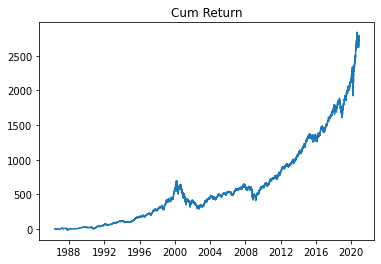

In [ ]:
line_plotting('Cum Return', 'Cum Return', 'linear')

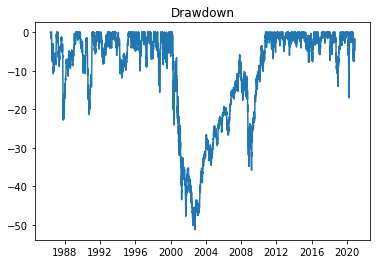

In [ ]:
line_plotting('Drawdown', 'Drawdown', 'linear')

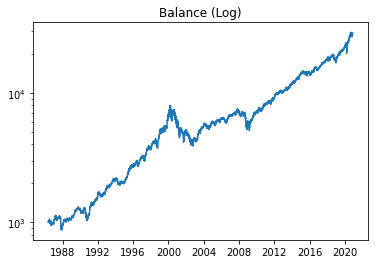

In [ ]:
line_plotting('Balance', 'Balance (Log)', 'log')

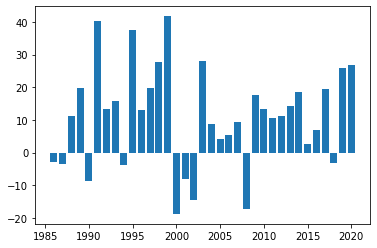

In [ ]:
bar_plotting('annual', 'Annual Return')

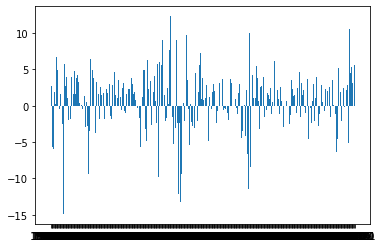

In [ ]:
bar_plotting('monthly', 'Monthly Return')